In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('src')))
import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import src.model_evaluation as me
reload(me)

<module 'src.model_evaluation' from '/home/labadmin/work/data-science-capstone-project/Kha Huynh/src/model_evaluation.py'>

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
from keras.utils import to_categorical

import tensorflow as tf

2023-10-21 23:04:11.981925: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-21 23:04:11.983145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 23:04:12.007772: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-21 23:04:12.008451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 23:04:12.477257: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# Data Loading

In [4]:
# df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
# df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
# df_demographic = dataLoader.load_demographic(df_diagnoses_icd)
# df_demographic = dataLoader.demographic_clean_AGE(df_demographic)
# df_labevents = dataLoader.load_labevents(df_demographic)
# # df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

# Dataset Extraction

In [4]:
hours_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]
top_n_features = [20]
dfs_dict = {}

The code below extract data by top n features and time t and save them into the folder. To save time, the files are uploaded and will be loaded for training the model

In [5]:
for top_n in top_n_features:
  dfs_dict[f'top{top_n}'] = {}
  for hour in hours_list:
    feature_filename=ROOT_DIR / 'data/potential_events.csv'
    output_filename = ROOT_DIR / f'data/Model input data/t{hour}_top{top_n}_sequence.csv'
    try:
      extracted_df = pd.read_csv(output_filename)
    except:
      extracted_df = dataLoader.create_train_data_sequence_new(df_labevents, df_demographic, df_desc_labitems, hours=hour, feature_no=top_n, output_filename = output_filename)
    extracted_df['CHARTTIME'] = pd.to_datetime(extracted_df['CHARTTIME'], format='%Y-%m-%d %H:%M:%S')
    dfs_dict[f'top{top_n}'][f't{hour}'] = extracted_df

# Data Processing

In [12]:
# import missingno as msno
# import matplotlib.pyplot as plt

# def visualise_missing_data(df):
#     """
#     Convert non-standard missing values (-999) to NaN and visualize the missing data using missingno,
#     without altering the original DataFrame.

#     Parameters:
#         df (pd.DataFrame): The DataFrame containing the dataset.

#     Returns:
#         None
#     """

#     # Create a copy of the DataFrame to avoid changing the original
#     df_copy = df.copy()

#     # Replace -999 with NaN in the copy
#     df_copy.replace(-999, np.nan, inplace=True)

#     plt.figure(figsize=(15, 7)) 

#     # Create a matrix plot for missing values
#     msno.matrix(df_copy)
#     plt.show()

#     # Create a bar plot for missing values
#     msno.bar(df_copy)
#     plt.show()

#     # Create a heatmap for missing values
#     msno.heatmap(df_copy)
#     plt.show()

# visualise_missing_data(dfs_dict_without_missing['top20']['t3'])

# Model Fitting

## Data preparation

In [10]:
top_features = [f'top{i}' for i in top_n_features] 
time_windows = [f't{i}' for i in hours_list]

In [11]:
from sklearn.impute import SimpleImputer

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(full_df, splitted_df):
    x_df = full_df.merge(splitted_df[['SUBJECT_ID', 'HADM_ID']])
    x_df['count'] = x_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_count = x_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_df = x_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_df, x_count, y_df

def preprocess_data(x_train_df, x_test_df, x_val_df):
    imputer = SimpleImputer(strategy='median', missing_values=np.nan)

    train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
    test_gendernum = x_test_df.GENDER_NUM.values
    val_gendernum = x_val_df.GENDER_NUM.values

    # impute X
    x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
    x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
    x_val = imputer.transform(x_val_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

    # Feature scaling - Standardisation
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train) #scale X
    x_test = scaler.transform(x_test)
    x_val = scaler.transform(x_val)

    x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
    x_test = np.column_stack((x_test, test_gendernum))
    x_val = np.column_stack((x_val, val_gendernum))

    return x_train, x_test, x_val

def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels

def data_preparation(x_train, x_train_count, y_train_df, 
                     x_test, x_test_count, y_test_df,
                     x_val, x_val_count, y_val_df):
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)
  val_data, act_val = ts_to_secs(x_val, x_val_count, y_val_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())
  print("[INFO] -- Shape of Validation Sections:")
  print(val_data.bounding_shape())

  return train_data, act_train, test_data, act_test, val_data, act_val

In [12]:
split_df_dict = {}
split_data_dict = {}

for top in top_features:
    dfs_list = []
    
    for time in time_windows:
        df_data = dfs_dict[top][time]
        admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

        x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                        admission['IS_SEPSIS'],
                                                        test_size=0.2,
                                                        )

        x_train_df, x_val_df, _, _ = df_split(x_train_df,  # dropping the target column for X values
                                                y_train_df,
                                                test_size=0.15,
                                                )

        x_train_df, x_train_count, y_train_df = create_data_df(df_data, x_train_df)
        x_test_df, x_test_count, y_test_df = create_data_df(df_data, x_test_df)
        x_val_df, x_val_count, y_val_df = create_data_df(df_data, x_val_df)

        # impute missing value and standardized data
        x_train, x_test, x_val = preprocess_data(x_train_df, x_test_df, x_val_df)
        x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(
            x_train, x_train_count, y_train_df, 
            x_test, x_test_count, y_test_df,
            x_val, x_val_count, y_val_df)
        
        # Store split dataframe
        split_df_dict[(top, time)] = {'x_train_df': x_train_df, 'x_test_df': x_test_df, 'x_val_df': x_val_df, 'y_train_df': y_train_df, 'y_test_df': y_test_df, 'y_val_df': y_val_df}
        # Store split data
        split_data_dict[(top, time)] = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'x_val': x_val, 'y_val': y_val}

[INFO] -- Shape of Training Sections:
tf.Tensor([23414     1    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([6887    1   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([4133    1   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Training Sections:
tf.Tensor([26783     6    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([7878    6   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([4727    6   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Training Sections:
tf.Tensor([28801     9    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([8471    9   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([5083    8   24], shape=(3,), dtype=int64)
[INFO] -- Shape of Training Sections:
tf.Tensor([30192    11    24], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([8881   11   24], shape=(3,), dtype=int6

## Model Definition

In [13]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

model_hist_dict = {}
models_dict = {}

In [17]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [7]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def LSTM_model(x_train):
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

In [8]:
for top in top_features:
  model_hist_dict[top] = {}
  for time in time_windows:
    print(f"----------------Start model {top}, {time}---------------------")

    x_train = split_data_dict[(top, time)]['x_train']
    y_train = split_data_dict[(top, time)]['y_train']
    x_test = split_data_dict[(top, time)]['x_test']
    y_test = split_data_dict[(top, time)]['y_test']
    x_val = split_data_dict[(top, time)]['x_val']
    y_val = split_data_dict[(top, time)]['y_val']

    model = LSTM_model(x_train)
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)

    checkpointer = ModelCheckpoint(filepath = f'models/LSTM_{top}_{time}_model.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=10, restore_best_weights=True)
    callbacks_list = [lr_scheduler, early_stop, checkpointer]
    
    sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))

    m = model.fit(x_train,y_train,
                  sample_weight=sample_weights,
                  # class_weight=me.get_class_weights(y_train_df),
                  epochs=50, batch_size=64, verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks=callbacks_list)
    model_hist_dict[top][time] = m

NameError: name 'top_features' is not defined

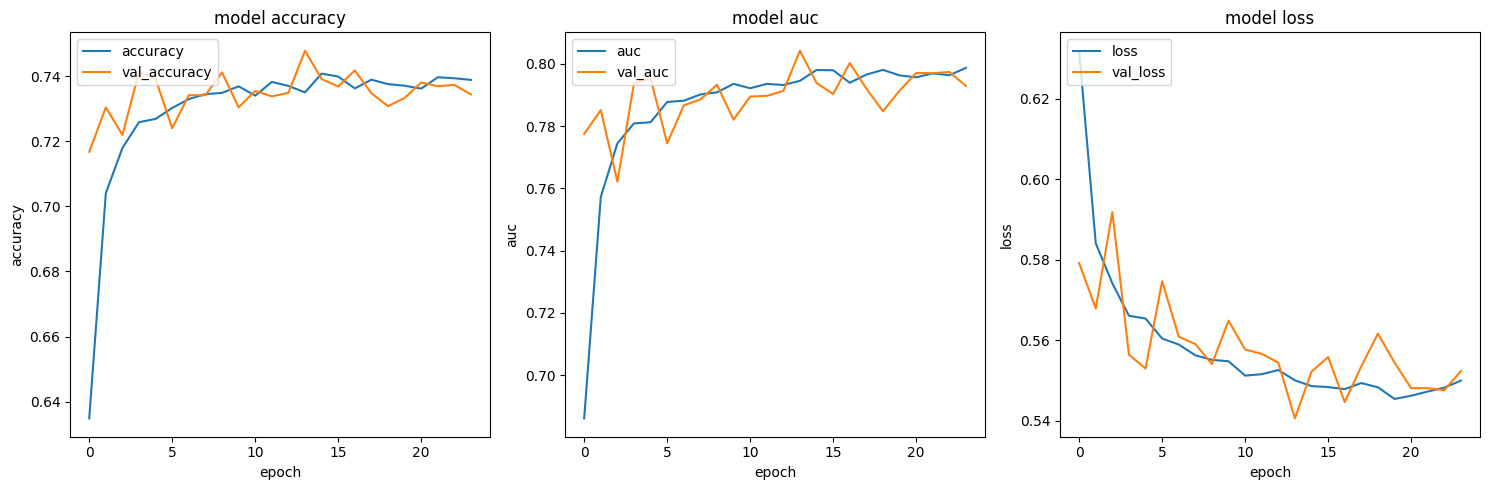

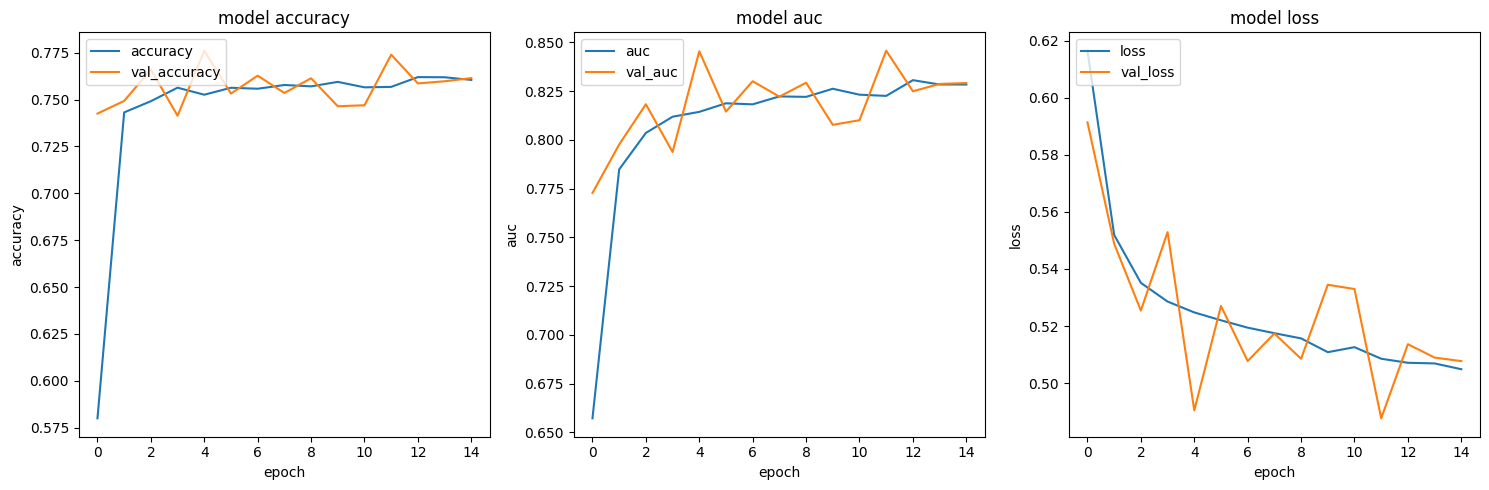

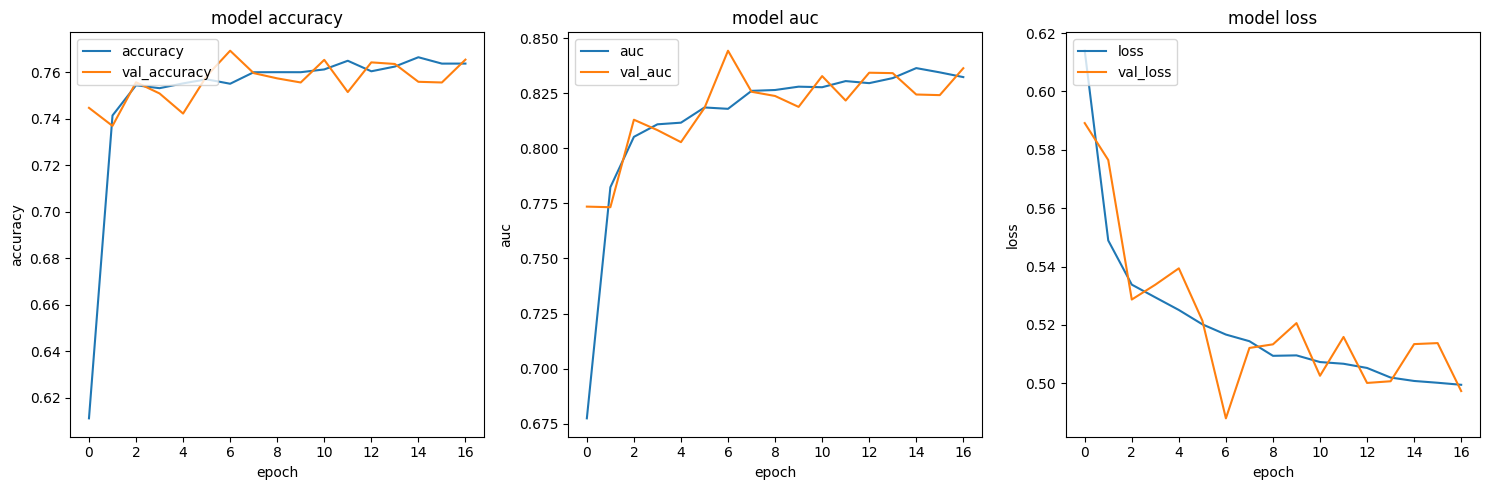

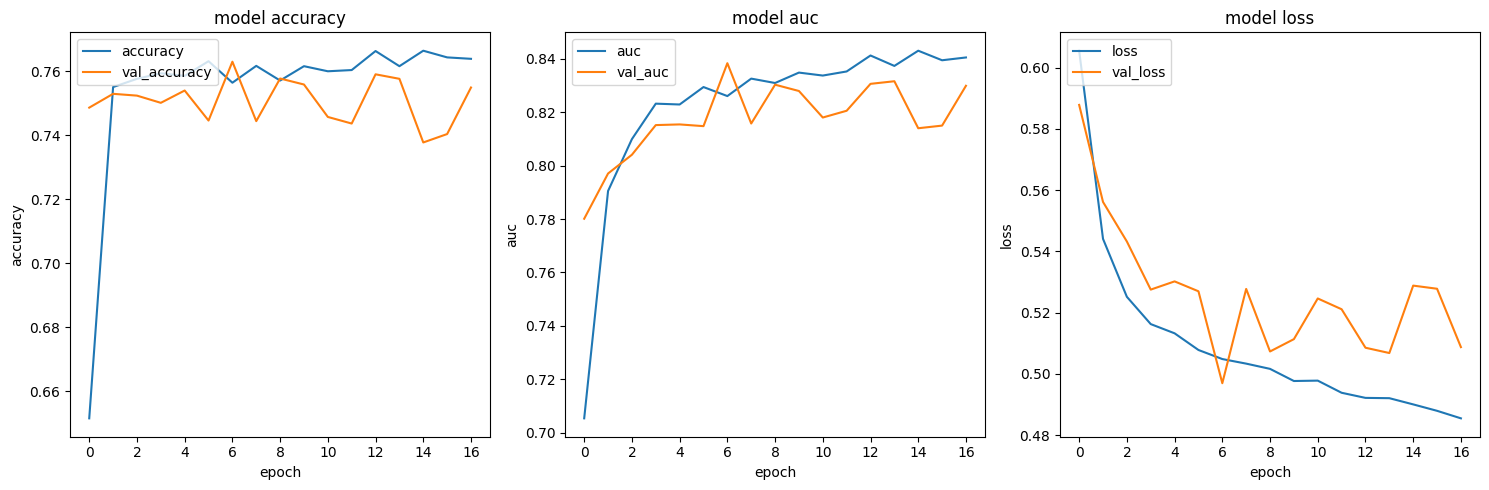

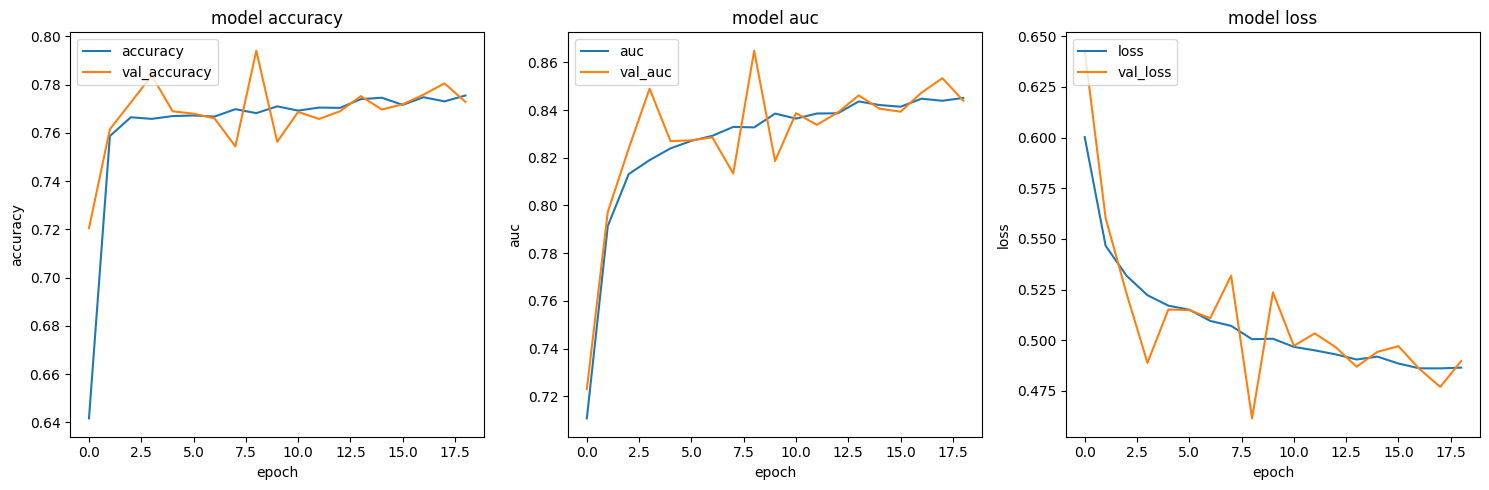

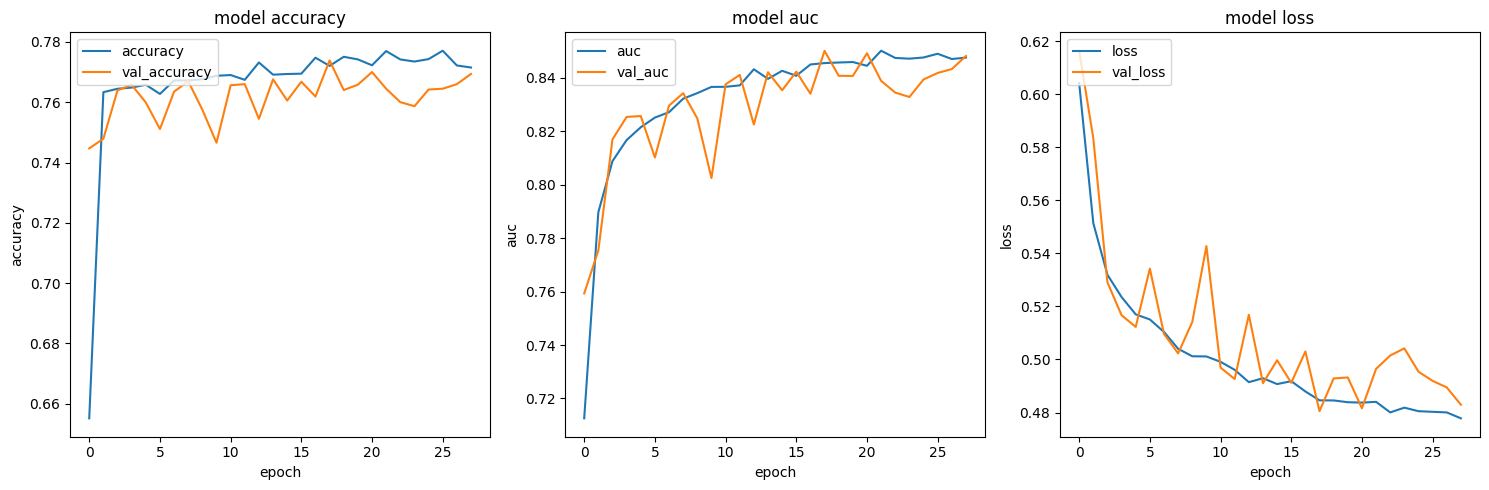

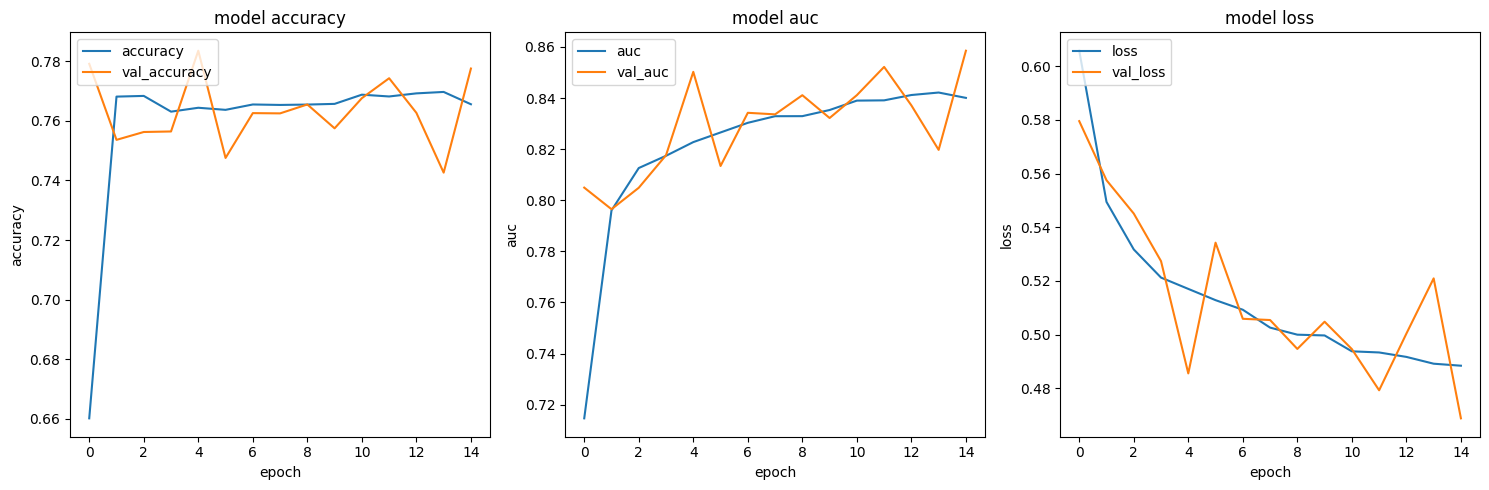

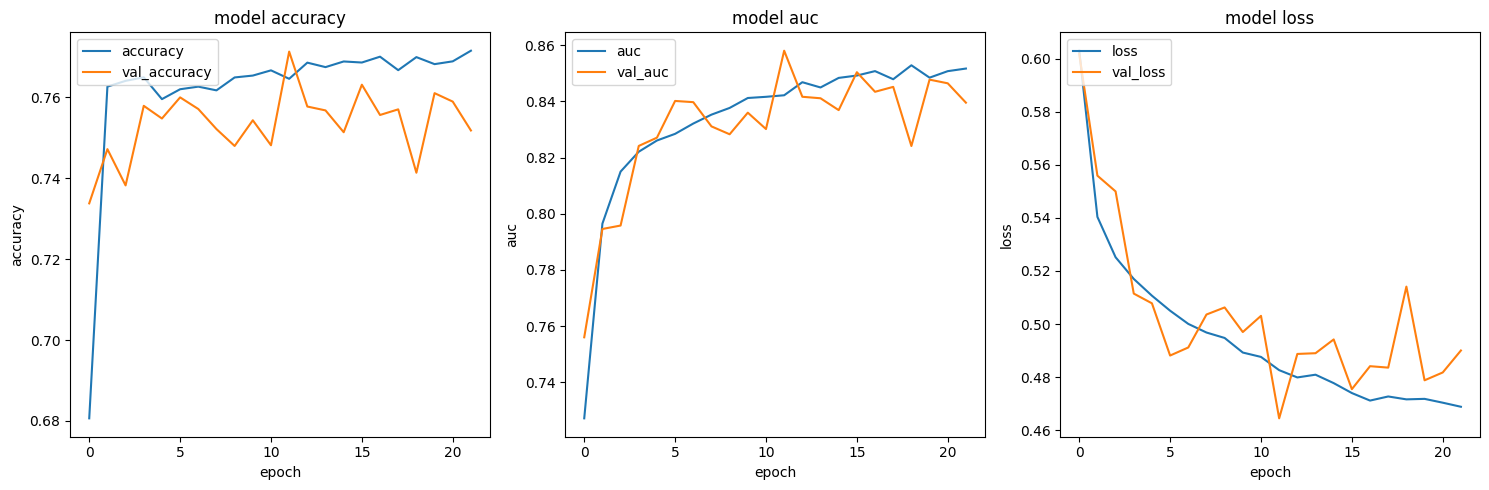

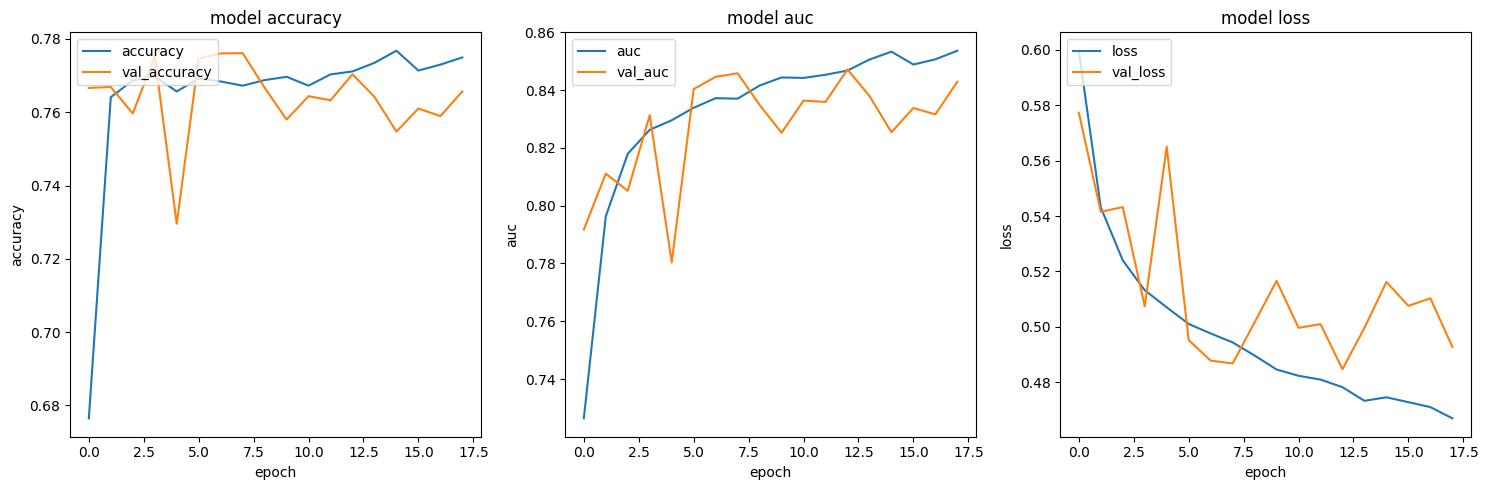

In [20]:
import matplotlib.pyplot as plt

for top in top_features:
  for time in time_windows:
    # Create a figure with two subplots side by side
    fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
    m_hist = model_hist_dict[top][time]
    
    # plt.plot(m.history['loss'])
    plt1.plot(m_hist.history['accuracy'])
    plt1.plot(m_hist.history['val_accuracy'])
    plt1.set_title('model accuracy')
    plt1.set_ylabel('accuracy')
    plt1.set_xlabel('epoch')
    plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

    # plt.plot(m.history['loss'])
    plt2.plot(m_hist.history['auc'])
    plt2.plot(m_hist.history['val_auc'])
    plt2.set_title('model auc')
    plt2.set_ylabel('auc')
    plt2.set_xlabel('epoch')
    plt2.legend(['auc', 'val_auc'], loc='upper left')

    # plt.plot(m.history['loss'])
    plt3.plot(m_hist.history['loss'])
    plt3.plot(m_hist.history['val_loss'])
    plt3.set_title('model loss')
    plt3.set_ylabel('loss')
    plt3.set_xlabel('epoch')
    plt3.legend(['loss', 'val_loss'], loc='upper left')

    plt.tight_layout()
    plt.show()

302/302 [==============================] - 1s 4ms/step


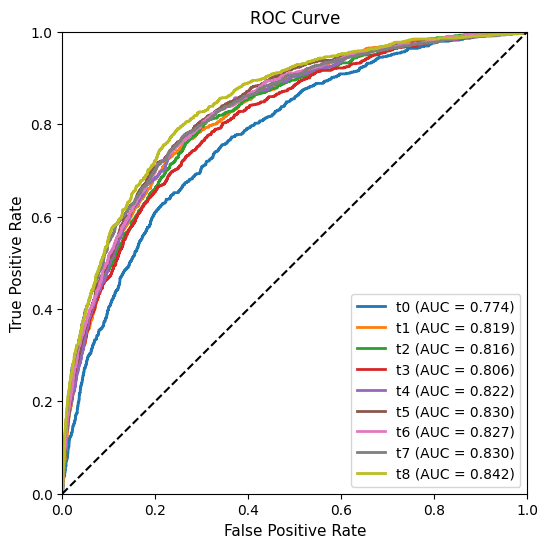

In [14]:
from keras.models import load_model
reload(me)

trained_models = {}
for top in top_features:
  trained_models[top] = {}
  for time in time_windows:  
    model = load_model(f'models/LSTM_{top}_{time}_model.hdf5')
    trained_models[top][time] = model

full_perf, test_perf = me.plot_combined_roc_curves_t(trained_models, split_data_dict, top_features, time_windows)

In [15]:
full_perf

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test,AUC
0,t0,0.725,0.703,0.267,0.248,0.694,0.662,0.385,0.361,0.774
1,t1,0.750,0.743,0.299,0.295,0.709,0.698,0.420,0.414,0.819
2,t2,0.755,0.738,0.297,0.279,0.723,0.701,0.421,0.399,0.816
3,t3,0.761,0.726,0.293,0.272,0.740,0.673,0.420,0.387,0.806
4,t4,0.757,0.743,0.307,0.300,0.705,0.676,0.428,0.416,0.822
5,t5,0.771,0.754,0.300,0.281,0.751,0.732,0.429,0.406,0.830
6,t6,0.753,0.753,0.288,0.287,0.717,0.718,0.410,0.410,0.827
7,t7,0.773,0.752,0.299,0.289,0.754,0.711,0.428,0.411,0.830
8,t8,0.769,0.766,0.294,0.291,0.749,0.747,0.423,0.419,0.842


In [16]:
test_perf

Model,t0,t1,t2,t3,t4,t5,t6,t7,t8
Balanced acc Test,0.703,0.743,0.738,0.726,0.743,0.754,0.753,0.752,0.766
Precision Test,0.248,0.295,0.279,0.272,0.3,0.281,0.287,0.289,0.291
Recall Test,0.662,0.698,0.701,0.673,0.676,0.732,0.718,0.711,0.747
F1 Test,0.361,0.414,0.399,0.387,0.416,0.406,0.41,0.411,0.419
AUC,0.774,0.819,0.816,0.806,0.822,0.83,0.827,0.83,0.842
